https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb

In [121]:
import matplotlib.pyplot as plt # creating visualizations
import numpy as np # basic math and random numbers
import torch # package for building functions with learnable parameters
import torch.nn as nn # prebuilt functions specific to neural networks
from torch.autograd import Variable # storing data while learning

In [122]:
def generate_data(n_samples):
    epsilon = np.random.normal(size=(n_samples))
    x_data = np.random.uniform(-10.5, 10.5, n_samples)
    y_data = 7*np.sin(0.75*x_data) + 0.5*x_data + epsilon
    return x_data, y_data
    
n_samples = 1000
x_data, y_data = generate_data(n_samples)

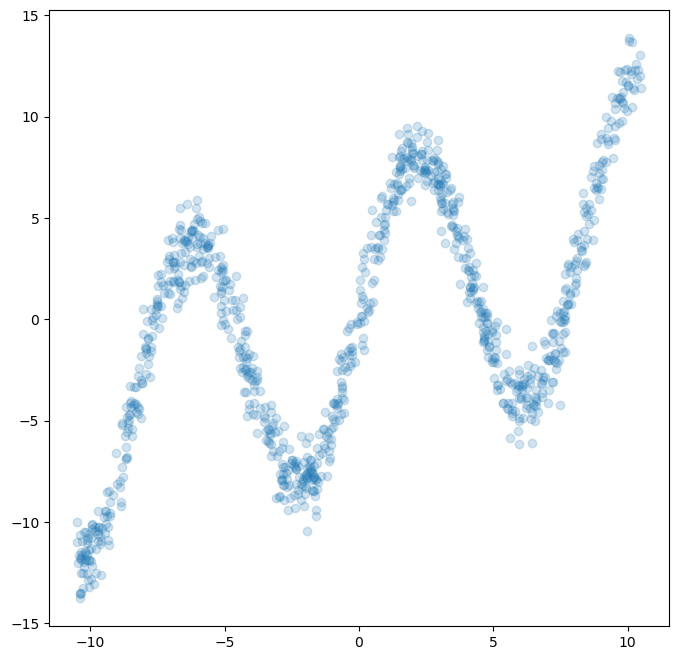

In [123]:
plt.figure(figsize=(8, 8))
plt.scatter(x_data, y_data, alpha=0.2)
plt.show()

We will use this data to train a neural network with one hidden layer. This neural network is described by the following equation:


: this function 
 takes 
 as input.
: weights for the input and output layers.
: biases for the input and output layers.
: a nonlinear activation function.
Let's create this network using 20 hidden nodes.

In [124]:
n_input = 1
n_hidden = 20
n_output = 1

# create the network (also called a "model" of the data)
network = nn.Sequential(nn.Linear(n_input, n_hidden),
                        nn.Tanh(),
                        nn.Linear(n_hidden, n_output))

In [125]:
loss_fn = nn.MSELoss()

In [126]:
optimizer = torch.optim.RMSprop(network.parameters())

In [127]:
# change data type and shape, move from numpy to torch
# note that we need to convert all data to np.float32 for pytorch
x_tensor = torch.from_numpy(np.float32(x_data).reshape(n_samples, n_input))
y_tensor = torch.from_numpy(np.float32(y_data).reshape(n_samples, n_input))
x_variable = Variable(x_tensor)
y_variable = Variable(y_tensor, requires_grad=False)

In [128]:
def train():
    for epoch in range(3000):
        y_pred = network(x_variable) # make a prediction
        loss = loss_fn(y_pred, y_variable) # compute the loss
        optimizer.zero_grad() # prepare the optimizer
        loss.backward() # compute the contribution of each parameter to the loss
        optimizer.step() # modify the parameters

        if epoch % 300 == 0:
            # print(epoch, loss.data[0])
            print(epoch)

train()

0
300
600
900
1200
1500
1800
2100
2400
2700


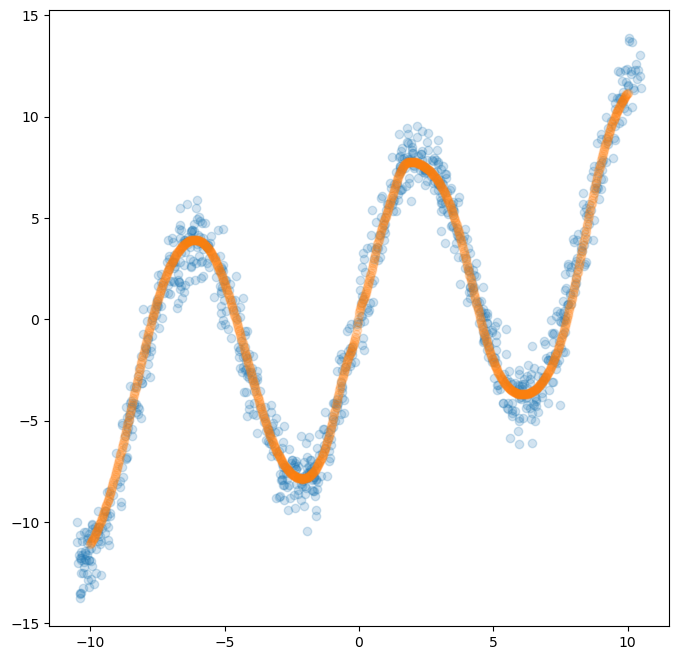

In [129]:
# evenly spaced samples from -10 to 10
x_test_data = np.linspace(-10, 10, n_samples)

# change data shape, move from numpy to torch
x_test_tensor = torch.from_numpy(np.float32(x_test_data).reshape(n_samples, n_input))
x_test_variable = Variable(x_test_tensor)
y_test_variable = network(x_test_variable)

# move from torch back to numpy
y_test_data = y_test_variable.data.numpy()

# plot the original data and the test data
plt.figure(figsize=(8, 8))
plt.scatter(x_data, y_data, alpha=0.2)
plt.scatter(x_test_data, y_test_data, alpha=0.2)
plt.show()

Now rotate

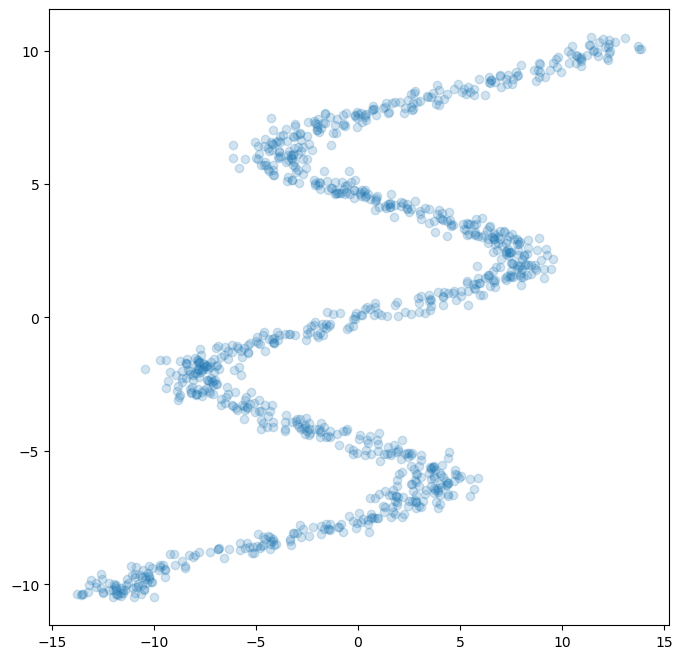

In [130]:
# plot x against y instead of y against x
plt.figure(figsize=(8, 8))
plt.scatter(y_data, x_data, alpha=0.2)
plt.show()

In [131]:
x_variable.data = y_tensor
y_variable.data = x_tensor

train()

0
300
600
900
1200
1500
1800
2100
2400
2700


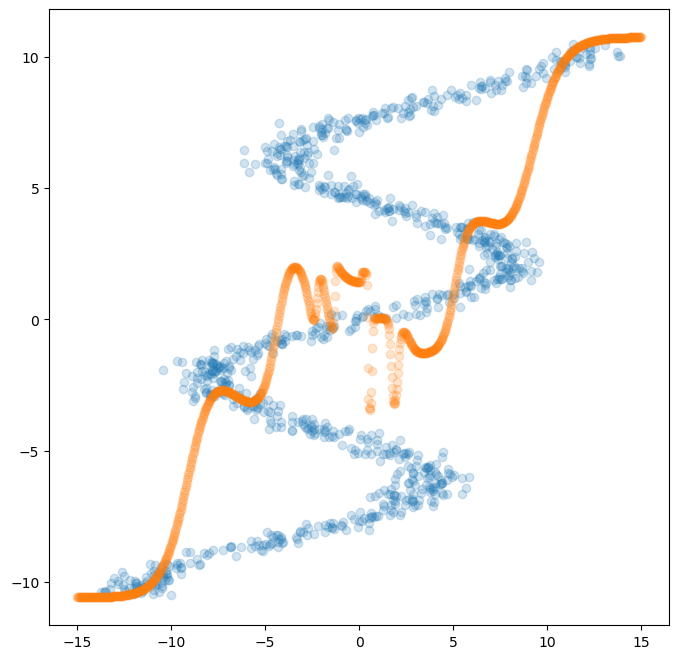

In [132]:
x_test_data = np.linspace(-15, 15, n_samples)
x_test_tensor = torch.from_numpy(np.float32(x_test_data).reshape(n_samples, n_input))
x_test_variable.data = x_test_tensor

y_test_variable = network(x_test_variable)

# move from torch back to numpy
y_test_data = y_test_variable.data.numpy()

# plot the original data and the test data
plt.figure(figsize=(8, 8))
plt.scatter(y_data, x_data, alpha=0.2)
plt.scatter(x_test_data, y_test_data, alpha=0.2)
plt.show()

## Mixture density network

In [133]:

class MDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        super(MDN, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)  

    def forward(self, x):
        z_h = self.z_h(x)
        pi = nn.functional.softmax(self.z_pi(z_h), -1)
        sigma = torch.exp(self.z_sigma(z_h))
        mu = self.z_mu(z_h)
        return pi, sigma, mu

In [134]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians
def gaussian_distribution(y, mu, sigma):
    # make |mu|=K copies of y, subtract mu, divide by sigma
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def mdn_loss_fn(pi, sigma, mu, y):
    result = gaussian_distribution(y, mu, sigma) * pi
    result = torch.sum(result, dim=1)
    result = -torch.log(result)
    return torch.mean(result)

In [135]:
network = MDN(n_hidden=20, n_gaussians=5)

In [136]:
optimizer = torch.optim.Adam(network.parameters())

In [137]:
mdn_x_data = y_data
mdn_y_data = x_data

mdn_x_tensor = y_tensor
mdn_y_tensor = x_tensor

x_variable = Variable(mdn_x_tensor)
y_variable = Variable(mdn_y_tensor, requires_grad=False)

In [138]:
def train_mdn():
    for epoch in range(10000):
        pi_variable, sigma_variable, mu_variable = network(x_variable)
        loss = mdn_loss_fn(pi_variable, sigma_variable, mu_variable, y_variable)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            # print(epoch, loss.data[0])
            print(epoch)

train_mdn()

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


<>:9: SyntaxWarning: invalid escape sequence '\P'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\P'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\m'
/var/folders/ql/nw995vq50pq3dlrxhk7mm4_40000gq/T/ipykernel_63821/3735412076.py:9: SyntaxWarning: invalid escape sequence '\P'
  ax1.set_title('$\Pi$')
/var/folders/ql/nw995vq50pq3dlrxhk7mm4_40000gq/T/ipykernel_63821/3735412076.py:11: SyntaxWarning: invalid escape sequence '\s'
  ax2.set_title('$\sigma$')
/var/folders/ql/nw995vq50pq3dlrxhk7mm4_40000gq/T/ipykernel_63821/3735412076.py:13: SyntaxWarning: invalid escape sequence '\m'
  ax3.set_title('$\mu$')


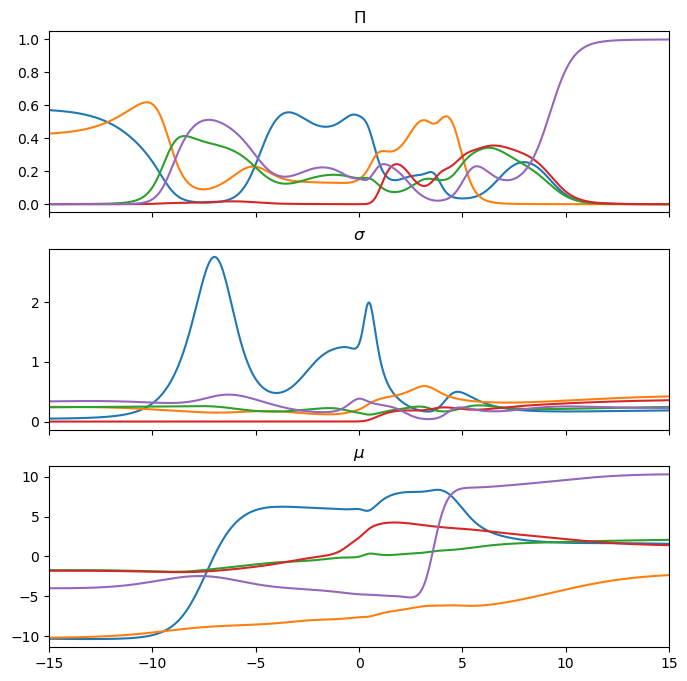

In [139]:
pi_variable, sigma_variable, mu_variable = network(x_test_variable)

pi_data = pi_variable.data.numpy()
sigma_data = sigma_variable.data.numpy()
mu_data = mu_variable.data.numpy()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
ax1.plot(x_test_data, pi_data)
ax1.set_title('$\Pi$')
ax2.plot(x_test_data, sigma_data)
ax2.set_title('$\sigma$')
ax3.plot(x_test_data, mu_data)
ax3.set_title('$\mu$')
plt.xlim([-15,15])
plt.show()

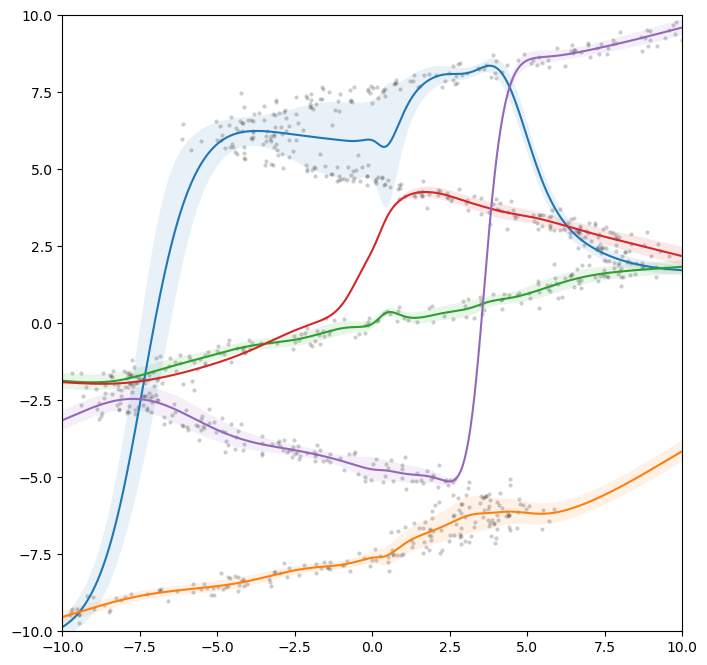

In [140]:
plt.figure(figsize=(8, 8), facecolor='white')
for mu_k, sigma_k in zip(mu_data.T, sigma_data.T):
    plt.plot(x_test_data, mu_k)
    plt.fill_between(x_test_data, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(mdn_x_data, mdn_y_data, marker='.', lw=0, alpha=0.2, c='black')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()

In [141]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(pi_data)

In [142]:
n_samples

1000

In [143]:
indices = (np.arange(n_samples), k)
rn = np.random.randn(n_samples)
sampled = rn * sigma_data[indices] + mu_data[indices]

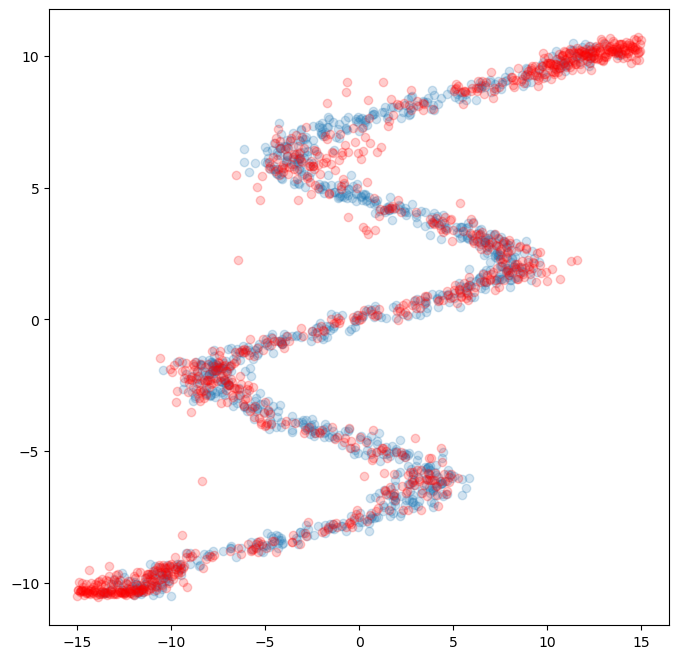

In [144]:
plt.figure(figsize=(8, 8))
plt.scatter(mdn_x_data, mdn_y_data, alpha=0.2)
plt.scatter(x_test_data, sampled, alpha=0.2, color='red')
plt.show()